<a href="https://www.kaggle.com/code/mohammadalqurtubi/contraceptive-clustering?scriptVersionId=102172847" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import plotly.graph_objects as go
import plotly.express as px
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

In [2]:
url_kota = "https://raw.githubusercontent.com/Alqurtubi17/contraceptive-clustering/master/Data%20Integration%20-%20Kota.csv"
url_prov = "https://raw.githubusercontent.com/Alqurtubi17/contraceptive-clustering/master/Data%20Integration%20-%20Provinsi.csv"
kota = pd.read_csv(url_kota)
prov = pd.read_csv(url_prov)

# PROVINCE

In [3]:
prov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Province   16 non-null     object
 1   IUD        16 non-null     int64 
 2   MOW        16 non-null     int64 
 3   MOP        16 non-null     int64 
 4   Condom     16 non-null     int64 
 5   Implant    16 non-null     int64 
 6   Injection  16 non-null     int64 
 7   Pill       16 non-null     int64 
dtypes: int64(7), object(1)
memory usage: 1.1+ KB


In [4]:
X = prov.drop("Province",axis=1)
cluster_prov = prov.drop("Province",axis=1)

## Initial

In [5]:
#KMeans Modelling
inertia = []
for i in range(2,11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

#Visualize Elbow Method
fig1 = go.Figure(data=go.Scatter(x=np.arange(2,11),y=inertia))
fig1.update_layout(title="Inertia vs Cluster Number",xaxis=dict(range=[0,11],title="Cluster Number"),
                  yaxis={'title':'Inertia'},
                 annotations=[
        dict(
            x=4,
            y=inertia[2],
            xref="x",
            yref="y",
            text="Elbow!",
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-40
        )
    ])

In [6]:
results = []
for i in range(2,11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X,  cluster_labels)
    results.append([i, silhouette_avg])
    
result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
pivot_km = pd.pivot_table(result, index = "n_clusters", values = "silhouette_score")

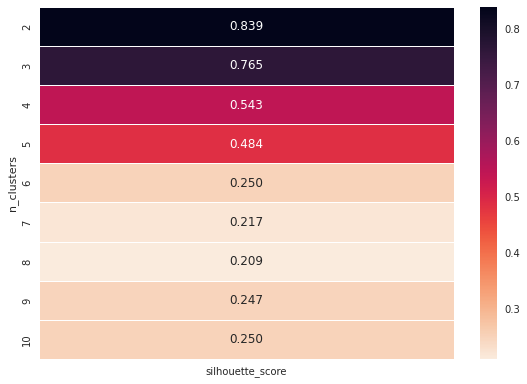

In [7]:
#Visualize Silhouette Score
plt.figure()
sns.heatmap(pivot_km, annot = True, linewidth = .5, fmt = '.3f', cmap = sns.cm.rocket_r)
plt.tight_layout()

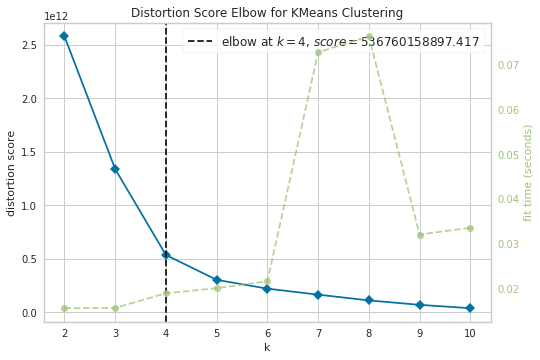

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
#Visualize Distortion Score Elbow
elbow = KElbowVisualizer(kmeans)
elbow.fit(X)
elbow.show()

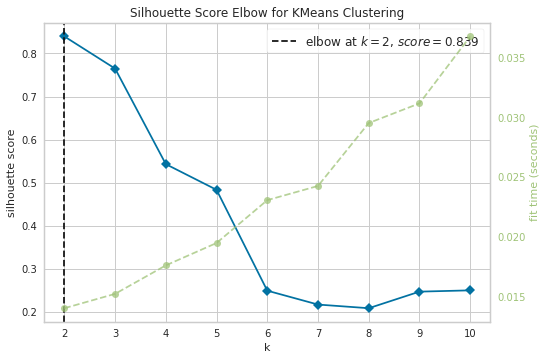

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [9]:
# Silhouette Score for K means
visualizer = KElbowVisualizer(kmeans,metric='silhouette', timings= True)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [10]:
kmeans = KMeans(n_clusters = elbow.elbow_value_).fit(X)
labels = pd.DataFrame(kmeans.labels_)
clustered_data = cluster_prov.assign(Cluster=labels)
kmeans.inertia_

536760158897.41675

In [11]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,IUD,MOW,MOP,Condom,Implant,Injection,Pill
Cluster,,,,,,,
0,42368.9,32450.0,13447.2,9018.4,47754.9,122870.9,46552.6
1,561196.5,259898.5,23702.0,131331.5,673589.0,2890968.0,797243.0
2,149531.5,63386.8,10261.8,79497.0,232507.0,515370.2,336564.0
3,849369.0,199371.0,34549.0,165510.0,544693.0,3865073.0,1695708.0


In [12]:
#Visualize Cluster
polar = clustered_data.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="Cluster", line_close=True,height=600,width=800)
fig4.show()

In [13]:
# kmeans = KMeans(
#         n_clusters = elbow.elbow_value_, init = "k-means++",
#         n_init = 10,
#         tol = 1e-04, random_state = 42)
# kmeans.fit(X)
# clusters=pd.DataFrame(X,columns=prov.drop("Provinsi",axis=1).columns)
# clusters['label']=kmeans.labels_
# polar=clusters.groupby("label").mean().reset_index()
# polar=pd.melt(polar,id_vars=["label"])
# fig4 = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=600,width=800)
# fig4.show()

## Scaling

In [14]:
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(X)
inertia = []
for i in range(1,11):
    kmeans = KMeans(
        n_clusters = i, init = "k-means++",
        n_init = 10,
        tol = 1e-04, random_state = 42)
    kmeans.fit(X_sc)
    inertia.append(kmeans.inertia_)

#Visualize Elbow Method
fig = go.Figure(data = go.Scatter(x=np.arange(1,11),y = inertia))
fig.update_layout(title = "Inertia vs Cluster Number",xaxis = dict(range=[0,11],title = "Cluster Number"),
                  yaxis ={'title':'Inertia'},
                 annotations = [
        dict(
            x = 5,
            y = inertia[4],
            xref = "x",
            yref = "y",
            text = "Elbow!",
            showarrow = True,
            arrowhead = 7,
            ax = 20,
            ay = -40
        )
    ])

In [15]:
results = []
for i in range(2,11):
    kmeans = KMeans(
        n_clusters = i, init = "k-means++",
        n_init = 10,
        tol = 1e-04, random_state = 42)
    kmeans.fit(X_sc)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.fit_predict(X_sc)
    silhouette_avg = silhouette_score(X_sc,  cluster_labels)
    results.append([i, silhouette_avg])
    
result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
pivot_km = pd.pivot_table(result, index = "n_clusters", values = "silhouette_score")

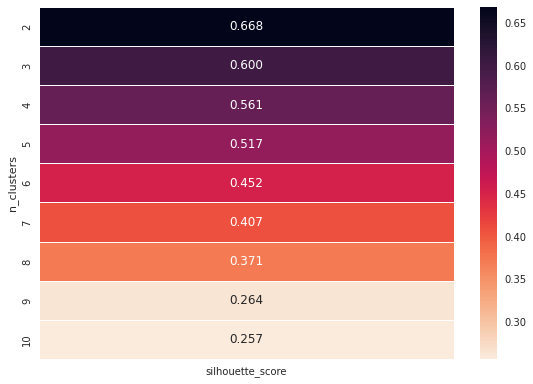

In [16]:
#Visualize Silhouette Score
plt.figure()
sns.heatmap(pivot_km, annot = True, linewidth = .5, fmt = '.3f', cmap = sns.cm.rocket_r)
plt.tight_layout()

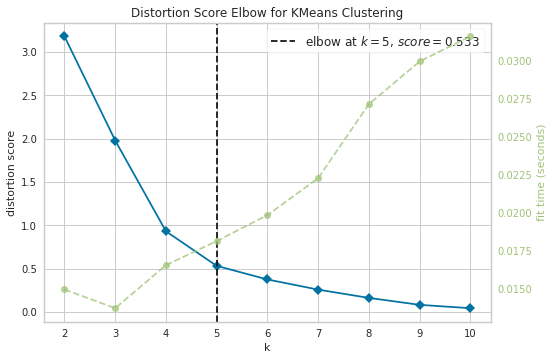

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
#Visualize Distortion Score Elbow
elbow = KElbowVisualizer(kmeans)
elbow.fit(X_sc)
elbow.show()

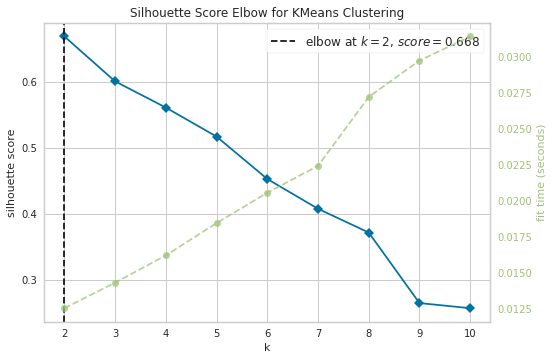

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [18]:
# Silhouette Score for K means
visualizer = KElbowVisualizer(kmeans,metric='silhouette', timings= True)
visualizer.fit(X_sc)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [19]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(X_sc)
labels = pd.DataFrame(kmeans.labels_)
clustered_data = cluster_prov.assign(Cluster=labels)
kmeans.inertia_

0.5332987187608874

In [20]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,IUD,MOW,MOP,Condom,Implant,Injection,Pill
Cluster,,,,,,,
0,181282.7,76564.0,12890.7,92879.0,273039.0,566594.3,366402.0
1,561196.5,259898.5,23702.0,131331.5,673589.0,2890968.0,797243.0
2,45520.9,13796.7,1380.3,11725.4,60045.9,162133.1,72373.4
3,25910.0,191735.0,110977.0,14988.0,292.0,8338.0,14662.0
4,849369.0,199371.0,34549.0,165510.0,544693.0,3865073.0,1695708.0


In [21]:
#Visualize Cluster
polar = clustered_data.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="Cluster", line_close=True,height=600,width=900)
fig4.show()

## Standarized

In [22]:
standart = StandardScaler()
X_st = standart.fit_transform(X)
inertia = []
for i in range(1,11):
    kmeans = KMeans(
        n_clusters = i, init = "k-means++",
        n_init = 10,
        tol = 1e-04, random_state = 42)
    kmeans.fit(X_st)
    inertia.append(kmeans.inertia_)

#Visualize Elbow Method
fig = go.Figure(data = go.Scatter(x=np.arange(1,11),y = inertia))
fig.update_layout(title = "Inertia vs Cluster Number",xaxis = dict(range=[0,11],title = "Cluster Number"),
                  yaxis ={'title':'Inertia'},
                 annotations = [
        dict(
            x = 5,
            y = inertia[4],
            xref = "x",
            yref = "y",
            text = "Elbow!",
            showarrow = True,
            arrowhead = 7,
            ax = 20,
            ay = -40
        )
    ])

In [23]:
results = []
for i in range(2,11):
    kmeans = KMeans(
        n_clusters = i, init = "k-means++",
        n_init = 10,
        tol = 1e-04, random_state = 42)
    kmeans.fit(X_st)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.fit_predict(X_st)
    silhouette_avg = silhouette_score(X_st,  cluster_labels)
    results.append([i, silhouette_avg])
    
result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
pivot_km = pd.pivot_table(result, index = "n_clusters", values = "silhouette_score")

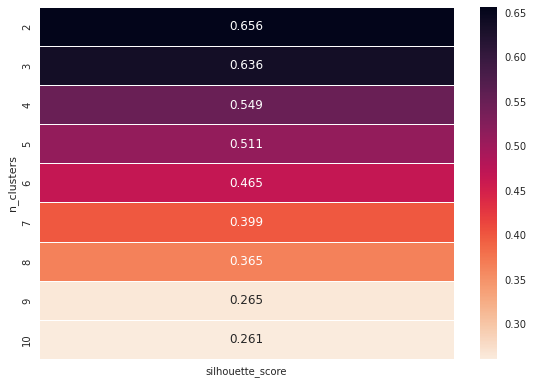

In [24]:
#Visualize Silhouette Score
plt.figure()
sns.heatmap(pivot_km, annot = True, linewidth = .5, fmt = '.3f', cmap = sns.cm.rocket_r)
plt.tight_layout()

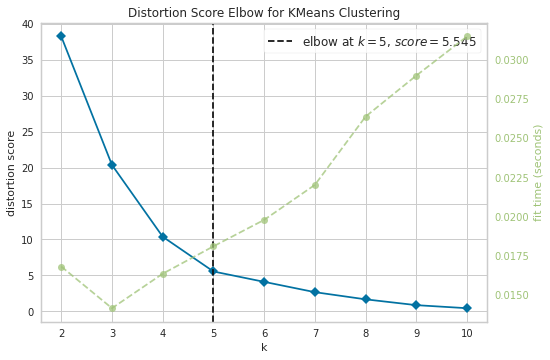

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
#Visualize Distortion Score Elbow
elbow = KElbowVisualizer(kmeans)
elbow.fit(X_st)
elbow.show()

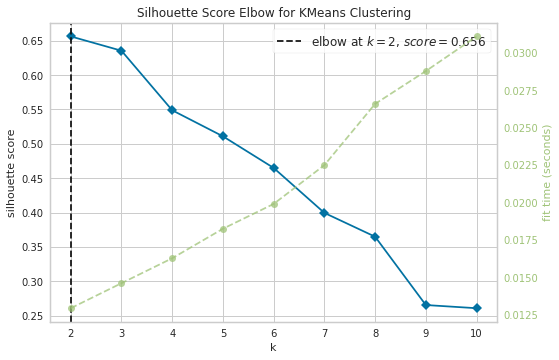

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [26]:
# Silhouette Score for K means
visualizer = KElbowVisualizer(kmeans,metric='silhouette', timings= True)
visualizer.fit(X_st)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [27]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(X_st)
labels = pd.DataFrame(kmeans.labels_)
clustered_data = cluster_prov.assign(Cluster=labels)
kmeans.inertia_

5.544916311346244

In [28]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,IUD,MOW,MOP,Condom,Implant,Injection,Pill
Cluster,,,,,,,
0,45520.9,13796.7,1380.3,11725.4,60045.9,162133.1,72373.4
1,561196.5,259898.5,23702.0,131331.5,673589.0,2890968.0,797243.0
2,25910.0,191735.0,110977.0,14988.0,292.0,8338.0,14662.0
3,181282.7,76564.0,12890.7,92879.0,273039.0,566594.3,366402.0
4,849369.0,199371.0,34549.0,165510.0,544693.0,3865073.0,1695708.0


In [29]:
#Visualize Cluster
polar = clustered_data.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="Cluster", line_close=True,height=600,width=800)
fig4.show()

# Kabupaten / Kota

In [30]:
kota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Kabupaten/Kota  304 non-null    object
 1   IUD             304 non-null    int64 
 2   MOW             304 non-null    int64 
 3   MOP             304 non-null    int64 
 4   Condom          304 non-null    int64 
 5   Implant         304 non-null    int64 
 6   Injection       304 non-null    int64 
 7   Pill            304 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 19.1+ KB


In [31]:
Xk = kota.drop("Kabupaten/Kota",axis=1)
cluster_kota = kota.drop("Kabupaten/Kota",axis=1)

## Initial

In [32]:
#KMeans Modelling
inertia = []
for i in range(2,11):
    kmeans = KMeans(
        n_clusters =i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42)
    kmeans.fit(Xk)
    inertia.append(kmeans.inertia_)

#Visualize Elbow Method
fig = go.Figure(data=go.Scatter(x=np.arange(1,11),y=inertia))
fig.update_layout(title="Inertia vs Cluster Number",xaxis=dict(range=[0,11],title="Cluster Number"),
                  yaxis={'title':'Inertia'},
                 annotations=[
        dict(
            x=4,
            y=inertia[3],
            xref="x",
            yref="y",
            text="Elbow!",
            showarrow=True,
            arrowhead=7,
            ax=20,
            ay=-40
        )
    ])

In [33]:
results = []
for i in range(2,11):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42)
    kmeans.fit(Xk)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.fit_predict(Xk)
    silhouette_avg = silhouette_score(Xk,  cluster_labels)
    results.append([i, silhouette_avg])
    
result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
pivot_km = pd.pivot_table(result, index = "n_clusters", values = "silhouette_score")

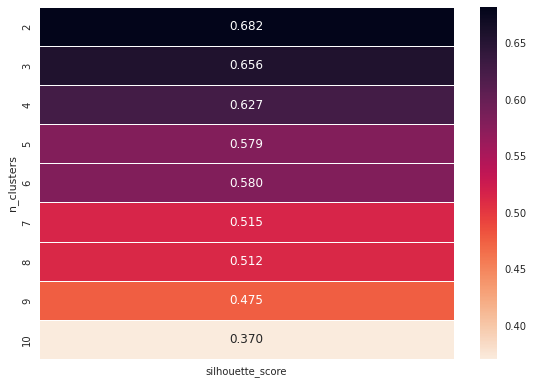

In [34]:
#Visualize Silhouette Score
plt.figure()
sns.heatmap(pivot_km, annot = True, linewidth = .5, fmt = '.3f', cmap = sns.cm.rocket_r)
plt.tight_layout()

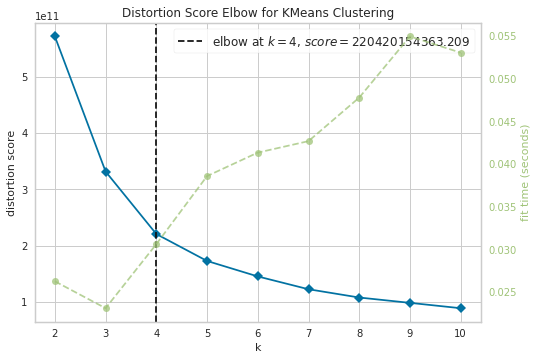

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
#Visualize Distortion Score Elbow
elbow = KElbowVisualizer(kmeans)
elbow.fit(Xk)
elbow.show()

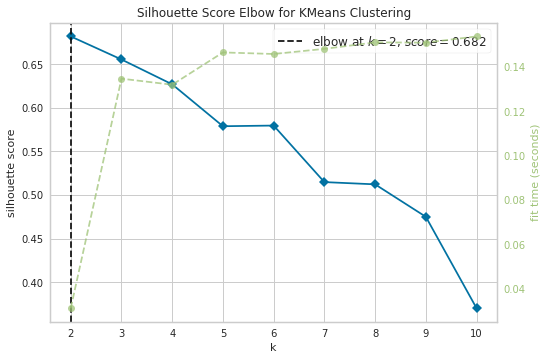

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [36]:
# Silhouette Score for K means
visualizer = KElbowVisualizer(kmeans,metric='silhouette', timings= True)
visualizer.fit(Xk)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [37]:
kmeans = KMeans(n_clusters = elbow.elbow_value_).fit(Xk)
labels = pd.DataFrame(kmeans.labels_)
clustered_data = cluster_kota.assign(Cluster=labels)
kmeans.inertia_

220420154363.20856

In [38]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,IUD,MOW,MOP,Condom,Implant,Injection,Pill
Cluster,,,,,,,
0,3026.5,2162.8,660.0,1192.9,4405.5,10610.8,4738.3
1,38961.8,10921.5,1715.1,8487.8,30414.7,157605.5,69103.0
2,55599.3,13513.7,2971.0,12406.7,32541.7,370202.7,154054.3
3,15929.0,6973.4,773.8,4644.1,20445.0,75431.6,25155.2


In [39]:
#Visualize Cluster
polar = clustered_data.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="Cluster", line_close=True,height=600,width=800)
fig4.show()

## Scaling

In [40]:
scaler = MinMaxScaler()
Xk_sc = scaler.fit_transform(Xk)
inertia = []
for i in range(1,11):
    kmeans = KMeans(
        n_clusters = i, init = "k-means++",
        n_init = 10,
        tol = 1e-04, random_state = 42)
    kmeans.fit(Xk_sc)
    inertia.append(kmeans.inertia_)

#Visualize Elbow Method
fig = go.Figure(data = go.Scatter(x=np.arange(1,11),y = inertia))
fig.update_layout(title = "Inertia vs Cluster Number",xaxis = dict(range=[0,11],title = "Cluster Number"),
                  yaxis ={'title':'Inertia'},
                 annotations = [
        dict(
            x = 4,
            y = inertia[3],
            xref = "x",
            yref = "y",
            text = "Elbow!",
            showarrow = True,
            arrowhead = 7,
            ax = 20,
            ay = -40
        )
    ])

In [41]:
results = []
for i in range(2,11):
    kmeans = KMeans(
        n_clusters = i, init = "k-means++",
        n_init = 10,
        tol = 1e-04, random_state = 42)
    kmeans.fit(Xk_sc)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.fit_predict(Xk_sc)
    silhouette_avg = silhouette_score(Xk_sc,  cluster_labels)
    results.append([i, silhouette_avg])
    
result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
pivot_km = pd.pivot_table(result, index = "n_clusters", values = "silhouette_score")

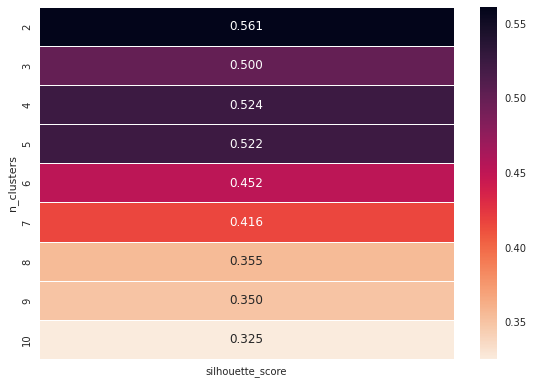

In [42]:
#Visualize Silhouette Score
plt.figure()
sns.heatmap(pivot_km, annot = True, linewidth = .5, fmt = '.3f', cmap = sns.cm.rocket_r)
plt.tight_layout()

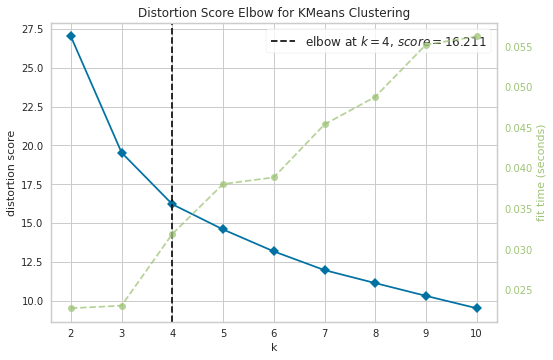

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
#Visualize Distortion Score Elbow
elbow = KElbowVisualizer(kmeans)
elbow.fit(Xk_sc)
elbow.show()

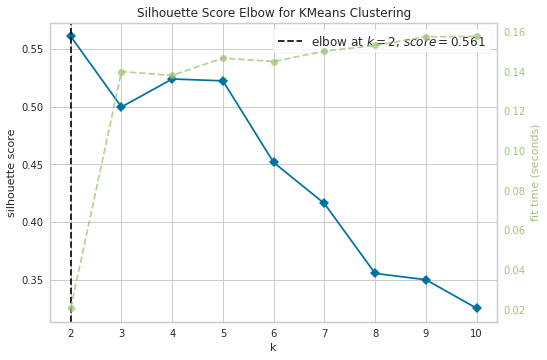

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [44]:
# Silhouette Score for K means
visualizer = KElbowVisualizer(kmeans,metric='silhouette', timings= True)
visualizer.fit(Xk_sc)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [45]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(Xk_sc)
labels = pd.DataFrame(kmeans.labels_)
clustered_data = cluster_kota.assign(Cluster=labels)
kmeans.inertia_

16.210705517257473

In [46]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,IUD,MOW,MOP,Condom,Implant,Injection,Pill
Cluster,,,,,,,
0,3214.9,1453.9,204.6,1044.5,4534.3,13704.3,5434.0
1,47814.5,12358.7,2129.2,12473.7,33562.8,170510.3,83869.6
2,15198.6,7305.1,788.7,4209.4,21356.3,81792.3,25845.1
3,1956.6,15006.4,9353.0,1220.6,14.5,666.6,1013.4


In [47]:
#Visualize Cluster
polar = clustered_data.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="Cluster", line_close=True,height=600,width=800)
fig4.show()

## Standarized

In [48]:
standart = StandardScaler()
Xk_st = standart.fit_transform(Xk)
inertia = []
for i in range(1,11):
    kmeans = KMeans(
        n_clusters = i, init = "k-means++",
        n_init = 10,
        tol = 1e-04, random_state = 42)
    kmeans.fit(Xk_st)
    inertia.append(kmeans.inertia_)

#Visualize Elbow Method
fig = go.Figure(data = go.Scatter(x=np.arange(1,11),y = inertia))
fig.update_layout(title = "Inertia vs Cluster Number",xaxis = dict(range=[0,11],title = "Cluster Number"),
                  yaxis ={'title':'Inertia'},
                 annotations = [
        dict(
            x = 4,
            y = inertia[3],
            xref = "x",
            yref = "y",
            text = "Elbow!",
            showarrow = True,
            arrowhead = 7,
            ax = 20,
            ay = -40
        )
    ])

In [49]:
results = []
for i in range(2,11):
    kmeans = KMeans(
        n_clusters = i, init = "k-means++",
        n_init = 10,
        tol = 1e-04, random_state = 42)
    kmeans.fit(Xk_st)
    inertia.append(kmeans.inertia_)
    cluster_labels = kmeans.fit_predict(Xk_st)
    silhouette_avg = silhouette_score(Xk_st,  cluster_labels)
    results.append([i, silhouette_avg])
    
result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
pivot_km = pd.pivot_table(result, index = "n_clusters", values = "silhouette_score")

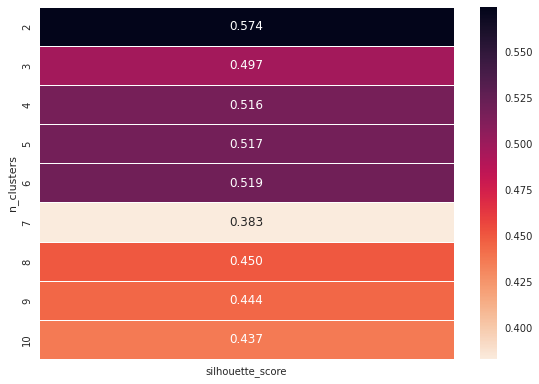

In [50]:
#Visualize Silhouette Score
plt.figure()
sns.heatmap(pivot_km, annot = True, linewidth = .5, fmt = '.3f', cmap = sns.cm.rocket_r)
plt.tight_layout()

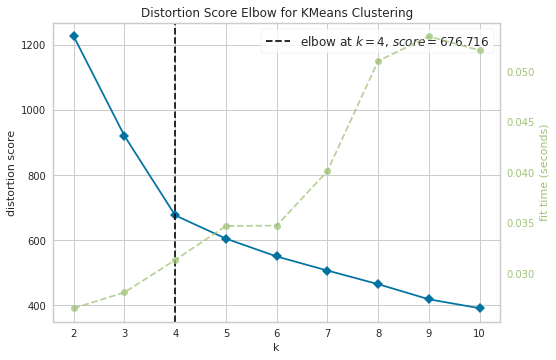

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
#Visualize Distortion Score Elbow
elbow = KElbowVisualizer(kmeans)
elbow.fit(Xk_st)
elbow.show()

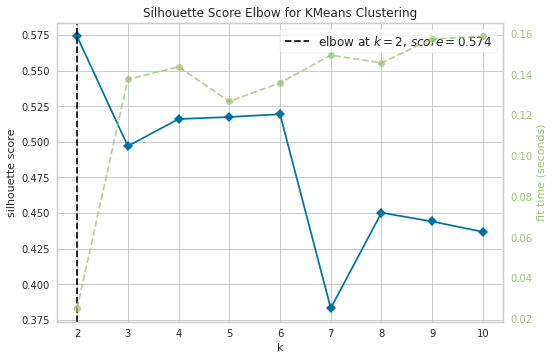

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [52]:
# Silhouette Score for K means
visualizer = KElbowVisualizer(kmeans,metric='silhouette', timings= True)
visualizer.fit(Xk_st)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [53]:
kmeans = KMeans(n_clusters = elbow.elbow_value_).fit(Xk_st)
labels = pd.DataFrame(kmeans.labels_)
clustered_data = cluster_kota.assign(Cluster=labels)
kmeans.inertia_

676.7159943702299

In [54]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,IUD,MOW,MOP,Condom,Implant,Injection,Pill
Cluster,,,,,,,
0,15370.0,7216.9,773.0,4035.7,21004.4,82315.7,25976.3
1,3049.0,1384.5,202.6,1059.3,4458.2,12206.4,4947.7
2,47988.2,12427.3,2151.7,12697.0,32994.9,173299.4,86329.9
3,1956.6,15006.4,9353.0,1220.6,14.5,666.6,1013.4


In [55]:
#Visualize Cluster
polar = clustered_data.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="Cluster", line_close=True,height=600,width=800)
fig4.show()

## GMM

### Kabupaten / Kota

In [56]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = elbow.elbow_value_).fit(Xk_st)
labels = pd.DataFrame(gmm.predict(Xk_st))
clustered_data = cluster_kota.assign(Cluster=labels)

In [57]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,IUD,MOW,MOP,Condom,Implant,Injection,Pill
Cluster,,,,,,,
0,1274.6,937.3,64.3,580.6,3833.4,8324.8,3413.9
1,34134.0,10062.4,1770.0,9541.1,26975.4,132138.8,62631.9
2,10862.4,4500.9,396.8,2816.6,14010.5,51723.8,15838.0
3,859.1,6609.9,3826.8,509.6,10.8,300.4,465.1


In [58]:
#Visualize Cluster
polar = clustered_data.groupby("Cluster").mean().reset_index()
polar = pd.melt(polar,id_vars=["Cluster"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="Cluster", line_close=True,height=600,width=800)
fig4.show()